In [64]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics as mt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.calibration import CalibratedClassifierCV



In [65]:
#load in data
df = pd.read_csv("cardio_train.csv", sep=";")

# We address the weight with reasonable weight, the other values probably are a mistake
df = df[df["weight"] < 200]
df = df[df["weight"] > 55]

# We address the height, the other values probably are a mistake
df = df[df["height"] < 200]
df = df[df["height"] > 130]

# Keeping only reasonable blood pressure measurements
df = df[df["ap_hi"] < 200]
df = df[df["ap_hi"] > 110]
df = df[df["ap_lo"] < 150]
df = df[df["ap_lo"] > 60]

# bin blood pressure groups based on the api hi/ lo variables
# bp is 1 - 5 where 1 is Normal, 2 is Elevated, 3 is HyperTension Stage1, 4 is HyperTensions Stage2, 5 is Hypertension Stage3
df['bp'] = np.where((df.ap_hi < 120) & (df.ap_lo < 80), 1, 0)
df['bp'] = np.where((df.ap_hi >= 120) & (df.ap_hi < 130) & (df.ap_lo < 80), 2, df.bp)
df['bp'] = np.where((df.ap_hi >= 130) & (df.ap_hi < 140) | ((df.ap_lo >= 80) & (df.ap_lo < 90)), 3, df.bp)
df['bp'] = np.where((df.ap_hi >= 140) | (df.ap_lo >= 90), 4, df.bp)
df['bp'] = np.where((df.ap_hi > 180) | (df.ap_lo > 120), 5, df.bp)

# compute the body mass index based on weight and height
df['bmi'] = df['weight'] / (df['height']/100)**2


# Train Test Splitting

In [66]:
#our target variable is cardio
y = df['cardio'].values
X = df.drop(['id', 'cardio'], axis=1).values

#make CV spit 80/20 object
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         


# All kinds of trees

In [67]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import cross_val_score

num_estimators = 50
# lets train some trees
clf_array = [
     ('Stump',              DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)),
    ('Tree',               DecisionTreeClassifier()),
    ('Random Trees',       RandomForestClassifier(max_depth=50, n_estimators=num_estimators)),
    ('Extra Random Trees', ExtraTreesClassifier(n_estimators=num_estimators,min_samples_split=2)),
    ('Boosted Tree',       GradientBoostingClassifier(n_estimators=num_estimators))
]
for clf in clf_array:
    acc = cross_val_score(clf[1],X,y,cv=3)
    print (clf[0], acc.mean())

Stump 0.7005447000527442
Tree 0.6204926566518795
Random Trees 0.6970575489694569
Extra Random Trees 0.6847868370795899
Boosted Tree 0.7224473218364276


# Base model: stump

In [68]:
clf = DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)

In [69]:
for train_indices, test_indices in cv_object.split(X, y):
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    clf.fit(X_train, y_train)
    y_hat = clf.predict(X_test)
    acc = mt.accuracy_score(y_test, y_hat)
    print(acc)

0.7029497691075299
0.7035152200546603
0.6935255866553577


## What's in the stump? ap_hi.

In [70]:
clf.feature_importances_

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [71]:
pd.Series(clf.best_estimator_.feature_importances_, index=df.drop(['id', 'cardio'], axis=1).columns)

AttributeError: 'DecisionTreeClassifier' object has no attribute 'best_estimator_'

# Finding Best Tree Depth

In [45]:
#first pass over finding best tree depth
param_grid = [
  {'max_depth': [1, 2, 5, 10, 20]}
 ]

tree = DecisionTreeClassifier(min_samples_leaf=1)
clf = GridSearchCV(tree, param_grid, scoring="f1",cv=cv_object)
clf.fit(X, y)

print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.741866 using {'max_depth': 5}
0.715787 (0.000700) with: {'max_depth': 1}
0.715787 (0.000700) with: {'max_depth': 2}
0.741866 (0.001399) with: {'max_depth': 5}
0.741669 (0.003808) with: {'max_depth': 10}
0.698036 (0.003665) with: {'max_depth': 20}


In [47]:

param_grid = [
  {'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11]}
 ]

tree = DecisionTreeClassifier(min_samples_leaf=1)
clf = GridSearchCV(tree, param_grid, scoring="f1",cv=cv_object)
clf.fit(X, y)

print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.750934 using {'max_depth': 4}
0.735580 (0.000575) with: {'max_depth': 3}
0.750934 (0.000830) with: {'max_depth': 4}
0.739829 (0.004009) with: {'max_depth': 5}
0.735710 (0.002497) with: {'max_depth': 6}
0.745072 (0.004087) with: {'max_depth': 7}
0.747454 (0.001245) with: {'max_depth': 8}
0.744808 (0.003953) with: {'max_depth': 9}
0.740619 (0.002016) with: {'max_depth': 10}
0.738614 (0.001016) with: {'max_depth': 11}


In [48]:
clf.best_estimator_.feature_importances_

array([0.1112605 , 0.        , 0.        , 0.        , 0.80108465,
       0.        , 0.07761428, 0.00712268, 0.        , 0.        ,
       0.        , 0.        , 0.00291789])

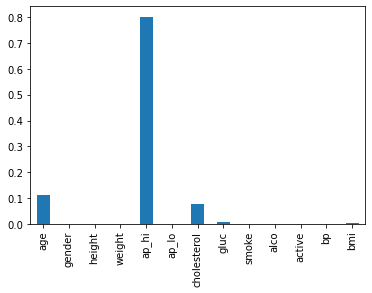

In [62]:
features = pd.Series(clf.best_estimator_.feature_importances_, index=df.drop(['id', 'cardio'], axis=1).columns)
features.plot(kind='bar')
plt.show()

# Random Forest with 6 depth

In [44]:
clf = RandomForestClassifier(max_depth=6, n_estimators=num_estimators)

for train_indices, test_indices in cv_object.split(X, y):
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    clf.fit(X_train, y_train)
    y_hat = clf.predict(X_test)
    acc = mt.f1_score(y_test, y_hat)
    print(acc)

0.7397694270879169
0.7395815016704765
0.7401229148375769


Automatically created module for IPython interactive environment
training score : 0.995 (multinomial)
training score : 0.976 (ovr)


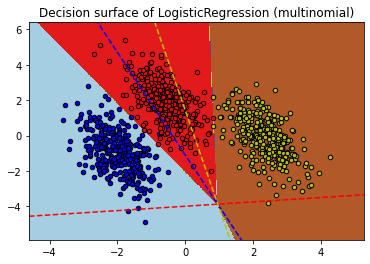

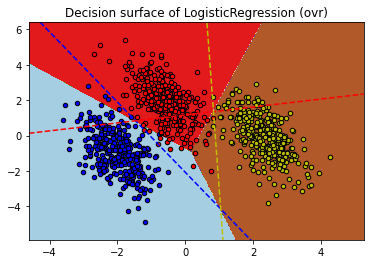

In [72]:
print(__doc__)
# Authors: Tom Dupre la Tour <tom.dupre-la-tour@m4x.org>
# License: BSD 3 clause
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
# make 3-class dataset for classification
centers = [[-5, 0], [0, 1.5], [5, -1]]
X, y = make_blobs(n_samples=1000, centers=centers, random_state=40)
transformation = [[0.4, 0.2], [-0.4, 1.2]]
X = np.dot(X, transformation)
for multi_class in ('multinomial', 'ovr'):
    clf = LogisticRegression(solver='sag', max_iter=100, random_state=42,
                             multi_class=multi_class).fit(X, y)
    # print the training scores
    print("training score : %.3f (%s)" % (clf.score(X, y), multi_class))
    # create a mesh to plot in
    h = .02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    plt.title("Decision surface of LogisticRegression (%s)" % multi_class)
    plt.axis('tight')
    # Plot also the training points
    colors = "bry"
    for i, color in zip(clf.classes_, colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired,
                    edgecolor='black', s=20)
    # Plot the three one-against-all classifiers
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    coef = clf.coef_
    intercept = clf.intercept_
    def plot_hyperplane(c, color):
        def line(x0):
            return (-(x0 * coef[c, 0]) - intercept[c]) / coef[c, 1]
        plt.plot([xmin, xmax], [line(xmin), line(xmax)],
                 ls="--", color=color)
    for i, color in zip(clf.classes_, colors):
        plot_hyperplane(i, color)
plt.show()